## Lab 7.01 Neural Network Binary Classification
_By: Jeff Hale_

This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. The goal is to predict whether a patient has heart disease (the *target* column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *TPU* by going to *Runtime* -> *Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

### Read data and load using pandas

#### Imports

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

Retrieve the csv file containing the heart dataset that ships with TensorFlow.

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

#### Load the csv file using pandas

In [3]:
heart_df = pd.read_csv('./data/heart.csv')

#### Inspect

In [4]:
heart_df.dropna(inplace=True)

In [5]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


In [6]:
heart_df.head(3)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


#### Check the value counts of the columns that are objects

In [7]:
heart_df['ChestPain'].value_counts()

asymptomatic    142
nonanginal       83
nontypical       49
typical          23
Name: ChestPain, dtype: int64

In [8]:
heart_df['Thal'].value_counts()

normal        164
reversable    115
fixed          18
Name: Thal, dtype: int64

In [9]:
heart_df['AHD'].value_counts(normalize=True)

No     0.538721
Yes    0.461279
Name: AHD, dtype: float64

You could load data into a format for TensorFlow using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset. You used to have to make your data into NumPy arrays for TensorFlow. Now you can just keep them as pandas DataFrames!

#### Set up X and y
Convert `ChestPain`, `Thal`, and `AHD` (the target) columns to numeric.
To convert features to numeric, feel free to give this friendlier OHE a try:
```
!pip install category_encoders 
import category_encoders as ce
```

In [10]:
#Make Target numeric
heart_df['AHD'] = heart_df['AHD']
heart_df_ = heart_df[['AHD']]

dict_ordinal = {
    'No': 0,
    'Yes' : 1, 
      }

#loop to get the job done
for i in heart_df_.columns:
    heart_df.replace({i: dict_ordinal},inplace = True)

#### Train-test split

In [11]:
y = heart_df[['AHD']] #if AHD is yes, then 1, if no then 0
X = heart_df.drop(columns =['AHD'])
assert len(X) == len(y)

In [12]:
#split into training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=.2, train_size = .8, stratify = y)

In [13]:
ohe = ce.OneHotEncoder()
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

C:\Users\jesse\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [14]:
ohe = ce.OneHotEncoder()
y_train = ohe.fit_transform(y_train)
y_test = ohe.transform(y_test)

C:\Users\jesse\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [15]:
# ohe = ce.OneHotEncoder()
# y_train = ohe.fit_transform(y_train)
# y_test = ohe.transform(y_test)
# y_train

In [16]:
X_train.shape

(237, 18)

In [17]:
y_train.shape

(237, 1)

In [18]:
#standardize
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#### Set the TensorFlow random seed

In [19]:
tf.random.set_seed(42)

## Create and train a model

#### Create model structure

In [21]:
#instantiate model
model = Sequential()

#input layer
n_input = X_train.shape[1]

model.add(Dense(n_input, 
                input_dim=n_input,
                activation='relu'
                ))

#dense layers

#output layer
model.add(Dense(1, activation='sigmoid'))

#### Visualize the structure

In [22]:
# Check neural network topology
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 19        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


#### Compile

In [23]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Make an EarlyStopping callback

In [24]:
early_stop = EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose = 1, mode='auto')

#### Fit the model

In [25]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=64, callbacks=[early_stop])

Epoch 1/25
4/4 [==============================] - 1s 321ms/step - loss: 0.0000e+00 - accuracy: 0.3392 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 2/25
4/4 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.3769 - val_loss: 0.0000e+00 - val_accuracy: 0.4333
Epoch 3/25
4/4 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.3995 - val_loss: 0.0000e+00 - val_accuracy: 0.4500
Epoch 4/25
4/4 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.4227 - val_loss: 0.0000e+00 - val_accuracy: 0.4500
Epoch 5/25
4/4 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.4458 - val_loss: 0.0000e+00 - val_accuracy: 0.5167
Epoch 6/25
4/4 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 0.4651 - val_loss: 0.0000e+00 - val_accuracy: 0.5500
Epoch 00006: early stopping


#### Plot model performance on the validation data (accuracy, recall, and precision)

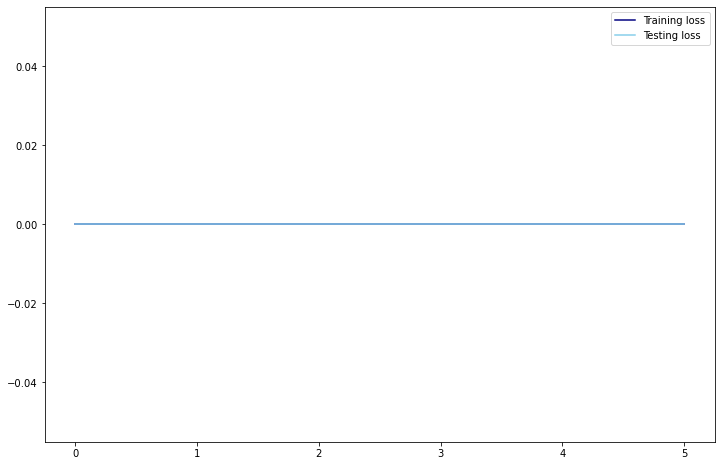

In [26]:
# Visualize the loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

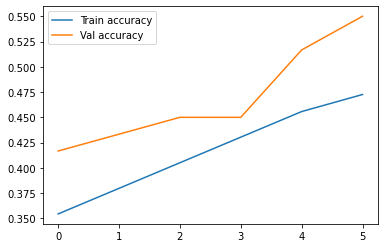

In [28]:
# Visualize loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

#### Save model

In [29]:
model.save('./nn_model') 

INFO:tensorflow:Assets written to: ./nn_model\assets


#### Load model

In [30]:
model = tf.keras.models.load_model('./nn_model')

#### Evaluate on test set 

In [31]:
history_test = model.fit(
X_test,
y_test,
validation_data=(X_train,y_train),
epochs=25,
batch_size=64,
callbacks=[early_stop])

Epoch 1/25
1/1 [==============================] - 1s 528ms/step - loss: 0.0000e+00 - accuracy: 0.5500 - val_loss: 0.0000e+00 - val_accuracy: 0.4810
Epoch 2/25
1/1 [==============================] - 0s 61ms/step - loss: 0.0000e+00 - accuracy: 0.5500 - val_loss: 0.0000e+00 - val_accuracy: 0.4979
Epoch 3/25
1/1 [==============================] - 0s 62ms/step - loss: 0.0000e+00 - accuracy: 0.5667 - val_loss: 0.0000e+00 - val_accuracy: 0.4979
Epoch 4/25
1/1 [==============================] - 0s 67ms/step - loss: 0.0000e+00 - accuracy: 0.5667 - val_loss: 0.0000e+00 - val_accuracy: 0.4979
Epoch 5/25
1/1 [==============================] - 0s 56ms/step - loss: 0.0000e+00 - accuracy: 0.5667 - val_loss: 0.0000e+00 - val_accuracy: 0.4979
Epoch 6/25
1/1 [==============================] - 0s 60ms/step - loss: 0.0000e+00 - accuracy: 0.5833 - val_loss: 0.0000e+00 - val_accuracy: 0.5021
Epoch 00006: early stopping


#### X_test predictions

In [32]:
y_pred=model.predict(X_test)

#### What do those numbers look like? Let's get rid of that exponential notation and just round the predictions.

In [33]:
y_pred = np.round(y_pred, 0)
y_pred = pd.DataFrame(y_pred) 

#### How is the model performing? 
Let's look at the confusion matrix using TF.

In [34]:
# Get predictions
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [35]:
#function to make a confusion matrix in a pandas dataframe

def conmat(y_test, preds, classes):
    conmat = confusion_matrix(y_test, preds)
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

preds = y_pred

conmat(y_test, preds, ['Yes', 'No'])

,Predicted Yes,Predicted No
Actual Yes,25,7
Actual No,17,11


Or just use sklearn's confusion matrix. 

#### Evaluate with other sklearn metrics

In [36]:
print(f"Recall score: {np.round(recall_score(y_test, model.predict_classes(X_test), average = 'weighted'),2)}")
print(f"Accuracy score: {np.round(accuracy_score(y_test, model.predict_classes(X_test),),2)}")
print(f"F1-score score: {np.round(f1_score(y_test, model.predict_classes(X_test),),2)}")
print(f"Precision score: {np.round(precision_score(y_test, model.predict_classes(X_test),),2)}")

C:\Users\jesse\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Recall score: 0.6
Accuracy score: 0.6
F1-score score: 0.48
Precision score: 0.61


### Make a null model

In [37]:
heart_df['AHD'].value_counts(normalize=True)

0    0.538721
1    0.461279
Name: AHD, dtype: float64

## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

In [38]:
#instantiate model
model1 = Sequential()

#input layer
n_input = X_train.shape[1]

#dense layers
model1.add(Dense(n_input, 
                input_dim=n_input,
                activation='relu',
                kernel_regularizer=l2(0.001)))
model1.add(Dense(10, 
                input_dim=n_input,
                activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(8, 
                input_dim=n_input,
                activation='relu',
                ))
model1.add(Dropout(0.2))

#output layer
model1.add(Dense(1, activation='sigmoid'))

In [39]:
#compile model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
#fit model to dataset
history1 = model1.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=10, batch_size=64, workers = -2)

Epoch 1/10
4/4 [==============================] - 1s 69ms/step - loss: 0.0182 - accuracy: 0.5088 - val_loss: 0.0181 - val_accuracy: 0.4979
Epoch 2/10
4/4 [==============================] - 0s 23ms/step - loss: 0.0181 - accuracy: 0.5032 - val_loss: 0.0180 - val_accuracy: 0.5443
Epoch 3/10
4/4 [==============================] - 0s 20ms/step - loss: 0.0180 - accuracy: 0.5956 - val_loss: 0.0180 - val_accuracy: 0.5570
Epoch 4/10
4/4 [==============================] - 0s 21ms/step - loss: 0.0179 - accuracy: 0.5775 - val_loss: 0.0179 - val_accuracy: 0.6160
Epoch 5/10
4/4 [==============================] - 0s 20ms/step - loss: 0.0179 - accuracy: 0.5606 - val_loss: 0.0178 - val_accuracy: 0.6414
Epoch 6/10
4/4 [==============================] - 0s 20ms/step - loss: 0.0178 - accuracy: 0.5968 - val_loss: 0.0177 - val_accuracy: 0.6835
Epoch 7/10
4/4 [==============================] - 0s 20ms/step - loss: 0.0177 - accuracy: 0.6561 - val_loss: 0.0177 - val_accuracy: 0.7215
Epoch 8/10
4/4 [===========

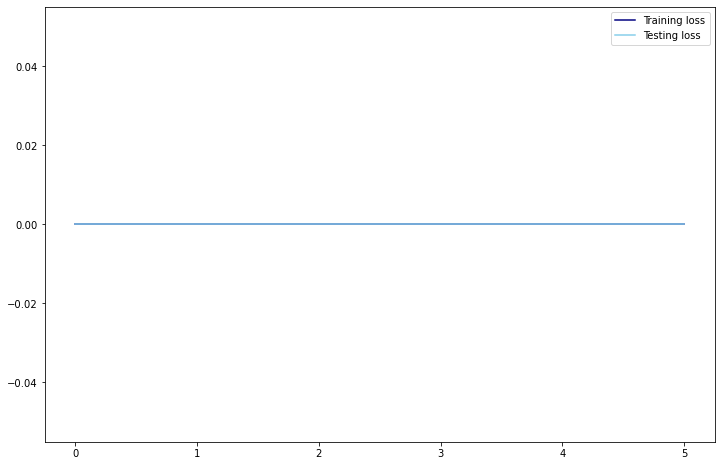

In [41]:
# Visualize the loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

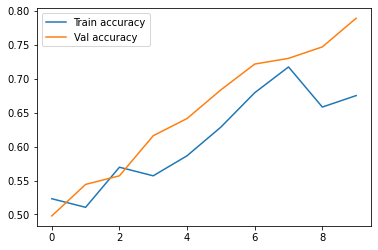

In [46]:
# Visualize loss
train_loss = history1.history['loss']
test_loss = history1.history['val_loss']

plt.plot(history1.history['accuracy'], label='Train accuracy')
plt.plot(history1.history['val_accuracy'], label='Val accuracy')
plt.legend();

In [53]:
print(f"Recall score: {np.round(recall_score(y_test, model1.predict_classes(X_test), average = 'weighted'),2)}")
print(f"Accuracy score: {np.round(accuracy_score(y_test, model1.predict_classes(X_test),),2)}")
print(f"F1-score score: {np.round(f1_score(y_test, model1.predict_classes(X_test),),2)}")
print(f"Precision score: {np.round(precision_score(y_test, model1.predict_classes(X_test),),2)}")

C:\Users\jesse\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Recall score: 0.87
Accuracy score: 0.87
F1-score score: 0.87
Precision score: 0.81


#### Save your best model. 


In [43]:
model1.save('./best_nn_model') 

INFO:tensorflow:Assets written to: ./best_nn_model\assets


In [44]:
y_pred=model.predict(X_test)

#### Compare with other algorithms
Compare your best neural net model to a scikit-learn LogisticRegression model. Also try a GradientBoostingClassifier.

#### Scale/Standardize for Logistic Regression


In [ ]:
#Already scaled data

#### Logistic Regression

In [50]:
lr = LogisticRegression()

In [52]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

C:\Users\jesse\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8734177215189873

#### Evaluate performance on metrics other than accuracy

In [55]:
print(f"Recall score: {np.round(recall_score(y_test, lr.predict(X_test), average = 'weighted'),2)}")
print(f"Accuracy score: {np.round(accuracy_score(y_test, lr.predict(X_test),),2)}")
print(f"F1-score score: {np.round(f1_score(y_test, lr.predict(X_test),),2)}")
print(f"Precision score: {np.round(precision_score(y_test, lr.predict(X_test),),2)}")

Recall score: 0.85
Accuracy score: 0.85
F1-score score: 0.83
Precision score: 0.88


### GradientBoosting

In [58]:
gbc = GradientBoostingClassifier()

In [59]:
gbc.fit(X_train, y_train)
gbc.score(X_train, y_train)

C:\Users\jesse\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9957805907172996

#### Evaluate performance on metrics other than accuracy

In [61]:
print(f"Recall score: {np.round(recall_score(y_test, gbc.predict(X_test), average = 'weighted'),2)}")
print(f"Accuracy score: {np.round(accuracy_score(y_test, gbc.predict(X_test),),2)}")
print(f"F1-score score: {np.round(f1_score(y_test, gbc.predict(X_test),),2)}")
print(f"Precision score: {np.round(precision_score(y_test, gbc.predict(X_test),),2)}")

Recall score: 0.78
Accuracy score: 0.78
F1-score score: 0.75
Precision score: 0.8


#### Which evaluation metric(s) are best to use in this problem?

Precision and specificity are good metrics to use for this problem. For healthcare, having false positives for heart issues is better than missing a true negative as the results may be fatal. 

#### Which model would you recommend for use? Why?

I would recommend using the Logistic Regression model. It is a simple and computationally efficient model. Additionally, it has very close scores to the other tested models and is white box (compared to the Neural Network which is black box) which means that feature importance can be extracted from the algorithm.


#### If you used Google Colab, download your notebook and put it in your Submissions repo. 🎉